# Data Pre-processing


In [114]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [115]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [116]:
data = pd.read_csv('../Data/train_data.csv', index_col='Claim Identifier')
data_test = pd.read_csv('../Data/test_data.csv', index_col='Claim Identifier')


C:\Users\isa\AppData\Local\Temp\ipykernel_6684\599180564.py:1: DtypeWarning: Columns (29) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('../Data/train_data.csv', index_col='Claim Identifier')


In [117]:
X_train = data.drop(columns=['Claim Injury Type'])
y_train = data['Claim Injury Type']


_____

# Empty rows
In the initial analysis we saw that the only features that has no missing values is `_Assembly Date_`. So let's check how many rows only have that feature filled and the rest of columns empty

In [118]:
X_train.drop(columns=['Assembly Date']).isna().all(axis=1).sum()


19445

In [119]:
X_train = data[~(data.drop(columns=['Assembly Date']).isna().all(axis=1) & data['Assembly Date'].notna())]
X_test = data_test[~(data_test.drop(columns=['Assembly Date']).isna().all(axis=1) & data_test['Assembly Date'].notna())]

In [120]:
X_train.drop(columns=['Assembly Date']).isna().all(axis=1).sum()


0

Here 19445 empty rows were dropped

_____

# Overlook of the features
This notebook will include pre processing of the following variables:
- Carrier Name 
- Attorney Representative
- OIICS Nature of Injury Description
- Industry Code
- Industry Code Description
- Medical Fee Region
- C-2 Date
- First Hearing Date
- WCIO Cause of Injury Description
- WCIO Cause of Injury Code
- WCIO Part of Body Code
- WCIO Part of Body Description
- WCIO Cause of Injury Code
- WCIO Cause of Injury Description
- WCIO Nature of Injury Description
- WCIO Nature of Injury Code

Since we dropped some rows in the previous section we should check again for the updated number of missing values for the features we are interest in

In [121]:
target_features = ['Carrier Name', 'Attorney/Representative', 'OIICS Nature of Injury Description', 
                   'Industry Code','Industry Code Description', 'Medical Fee Region', 'C-2 Date', 'First Hearing Date','WCIO Cause of Injury Code','WCIO Cause of Injury Description',
                   'WCIO Part Of Body Code','WCIO Part Of Body Description','WCIO Cause of Injury Description','WCIO Cause of Injury Code','WCIO Nature of Injury Description',]

In [122]:
X_train[target_features].isnull().sum()/X_train.shape[0]*100

Carrier Name                            0.000000
Attorney/Representative                 0.000000
OIICS Nature of Injury Description    100.000000
Industry Code                           1.734765
Industry Code Description               1.734765
Medical Fee Region                      0.000000
C-2 Date                                2.536470
First Hearing Date                     73.729761
WCIO Cause of Injury Code               2.724615
WCIO Cause of Injury Description        2.724615
WCIO Part Of Body Code                  2.975823
WCIO Part Of Body Description           2.975823
WCIO Cause of Injury Description        2.724615
WCIO Cause of Injury Code               2.724615
WCIO Nature of Injury Description       2.727577
dtype: float64

The features _`Carrier Name`_,  _`Attorney/Representative`_ and _`Medical Fee Region`_ no longer have missing values. Let's look at the others

### OIICS Nature of Injury Description
Between all the complains this feature is never filled, so we can drop it

In [123]:
# drop OIICS Nature of Injury Description
X_train = X_train.drop(columns=['OIICS Nature of Injury Description'])
X_test = X_test.drop(columns=['OIICS Nature of Injury Description'])

### First Hearing Date
This feature also has a high percentage of missing values. According to the provided information for this project, 'A blank date means the claim has not yet had a hearing held'. So we should create a label for the ones that hadn't had a hearing yet, we will simply call it 'N/A'

In [124]:
# transform First Hearing Date into pd.datetime
X_train['First Hearing Date'] = pd.to_datetime(X_train['First Hearing Date'])
X_test['First Hearing Date'] = pd.to_datetime(X_test['First Hearing Date'])

In [125]:
# fill NA with 'N/A'
X_train['First Hearing Date'] = X_train['First Hearing Date'].fillna('N/A')
X_test['First Hearing Date'] = X_test['First Hearing Date'].fillna('N/A')
df['First Hearing Date'].isna().sum()

0

To assist in the information that this feature can provide we can create another feature called _`Has First Hearing Date`_ - a binary value that indicates if the user has had it's first hearing date

In [126]:
# create Has First Hearing Date based on if is 'N/A' or not
X_train['Has First Hearing Date'] = X_train['First Hearing Date'].apply(lambda x: 0 if x == 'N/A' else 1)
X_test['Has First Hearing Date'] = X_test['First Hearing Date'].apply(lambda x: 0 if x == 'N/A' else 1)

In [127]:
X_train['Has First Hearing Date'].value_counts()

Has First Hearing Date
0    423228
1    150798
Name: count, dtype: int64

### C-2 Date
Here we can use the same approach filling the NaNs with N/A

In [128]:
X_train['C-2 Date'] = pd.to_datetime(X_train['C-2 Date'])
X_test['C-2 Date'] = pd.to_datetime(X_test['C-2 Date'])

X_train['C-2 Date'] = X_train['C-2 Date'].fillna('N/A')
X_test['C-2 Date'] = X_test['C-2 Date'].fillna('N/A')


### Codes and Descriptions
This section will analyse data related to codes and their descriptions

In [129]:
df_codes = X_train[[col for col in X_train.columns if 'Code' in col]]
df_codes.drop(columns=['Industry Code Description', 'Zip Code'], inplace=True)

df_description = X_train[[col for col in X_train.columns if 'Description' in col]]

C:\Users\isa\AppData\Local\Temp\ipykernel_6684\3732407763.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_codes.drop(columns=['Industry Code Description', 'Zip Code'], inplace=True)


In [130]:
# ensure that all codes are objects
df_codes = df_codes.astype('object')

df_codes.describe()

,Industry Code,WCIO Cause of Injury Code,WCIO Nature of Injury Code,WCIO Part Of Body Code
count,564068.0,558386.0,558369.0,556944.0
unique,24.0,77.0,56.0,57.0
top,62.0,56.0,52.0,42.0
freq,114339.0,46610.0,153373.0,51862.0


In [131]:
#check the order of the codes
df_codes.columns


Index(['Industry Code', 'WCIO Cause of Injury Code',
       'WCIO Nature of Injury Code', 'WCIO Part Of Body Code'],
      dtype='object')

In [132]:
#check the order of the descriptions
df_description.columns

Index(['Industry Code Description', 'WCIO Cause of Injury Description',
       'WCIO Nature of Injury Description', 'WCIO Part Of Body Description'],
      dtype='object')

In [133]:
def code_description_consistency(df, code_column, description_column):
    """
    Checks the one-to-one consistency between a code and description column in a DataFrame.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - code_column (str): The name of the column representing codes.
    - description_column (str): The name of the column representing descriptions.
    
    Returns:
    - tuple: A tuple with two boolean values:
        - codes_match_descriptions (bool): True if each code has a unique description.
        - descriptions_match_codes (bool): True if each description has a unique code.
    """
    # Remove rows with missing values in either the code or description columns
    df_non_null = df.dropna(subset=[code_column, description_column])

    # Check if each code maps to a unique description
    code_consistency = df_non_null.groupby(code_column)[description_column].nunique() == 1

    # Check if each description maps to a unique code
    description_consistency = df_non_null.groupby(description_column)[code_column].nunique() == 1

    # Check overall consistency
    codes_match_descriptions = code_consistency.all()
    descriptions_match_codes = description_consistency.all()

    return codes_match_descriptions, descriptions_match_codes

In [134]:
for code_col, desc_col in zip(df_codes.columns, df_description.columns):
    # Get the consistency check result
    result = code_description_consistency(X_train, code_col, desc_col)
    
    # Print the names of the columns along with the result
    print(f"Checking consistency between '{code_col}' and '{desc_col}': {result}")

Checking consistency between 'Industry Code' and 'Industry Code Description': (True, False)
Checking consistency between 'WCIO Cause of Injury Code' and 'WCIO Cause of Injury Description': (True, False)
Checking consistency between 'WCIO Nature of Injury Code' and 'WCIO Nature of Injury Description': (True, True)
Checking consistency between 'WCIO Part Of Body Code' and 'WCIO Part Of Body Description': (True, False)


So codes match the same description but the same does not happen for the description since we have the same description in different codes

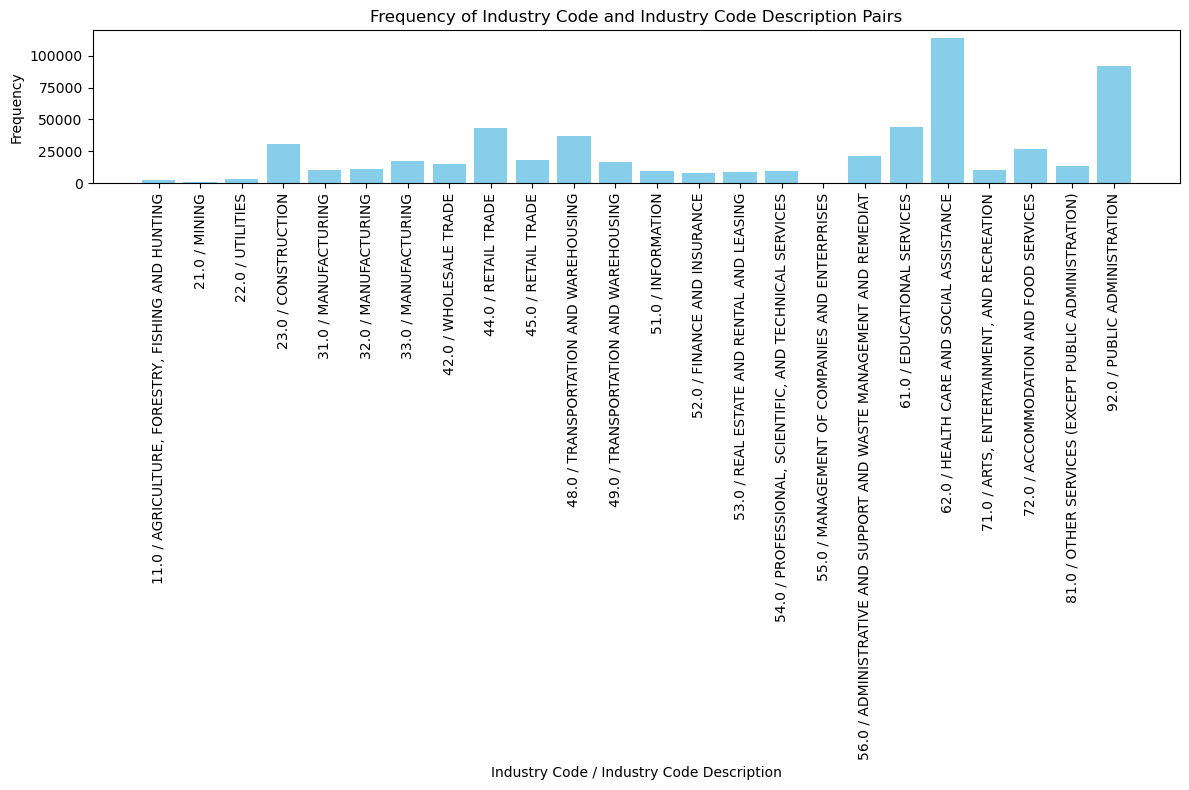

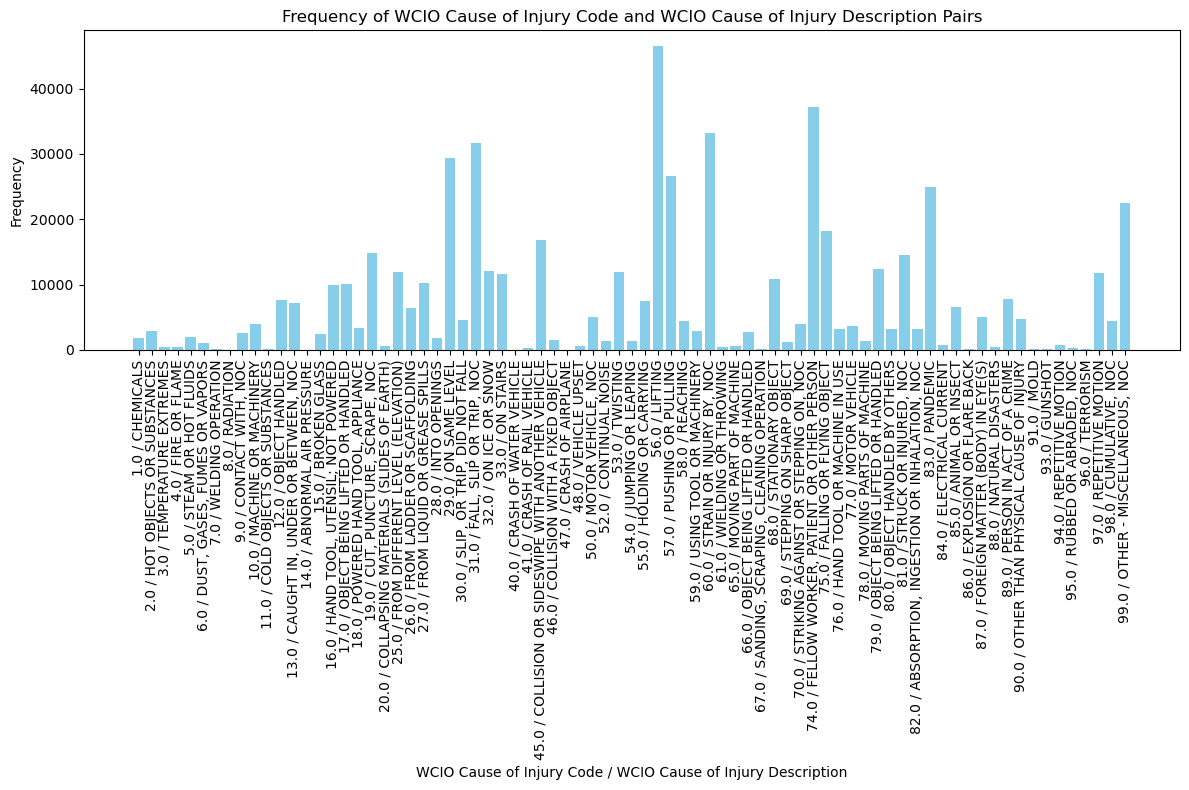

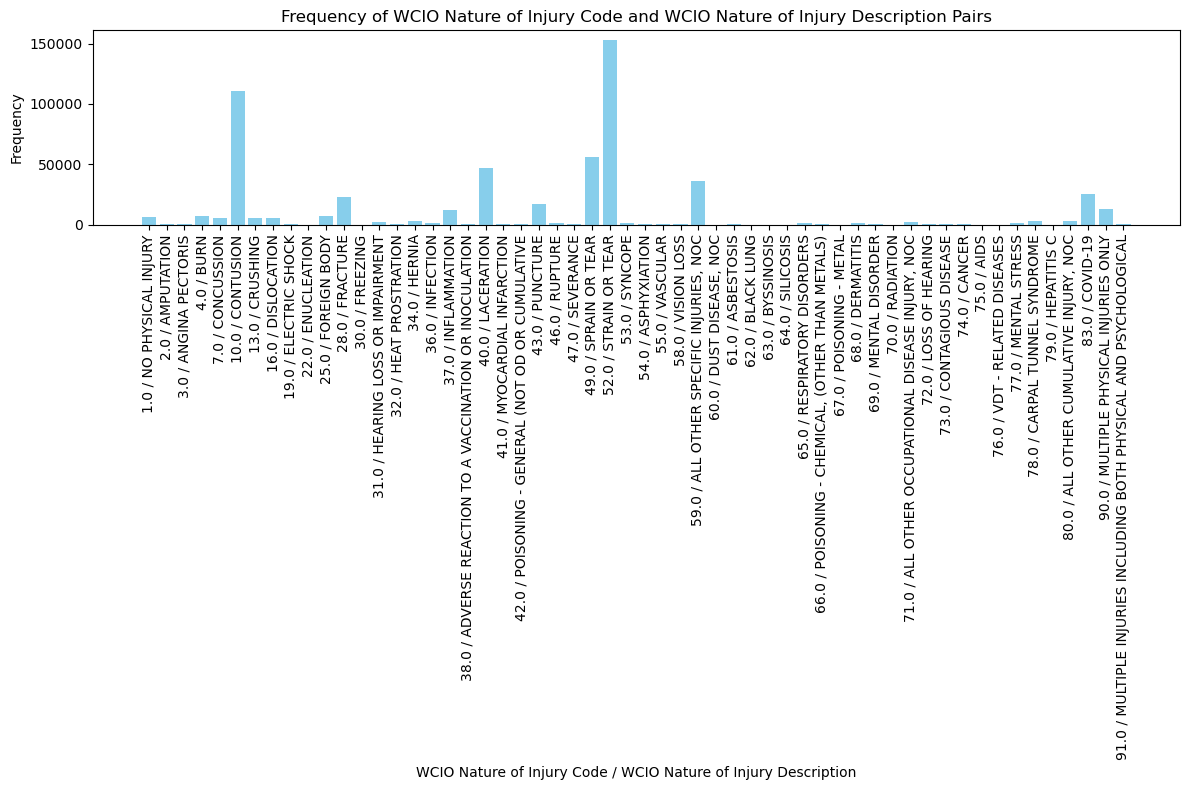

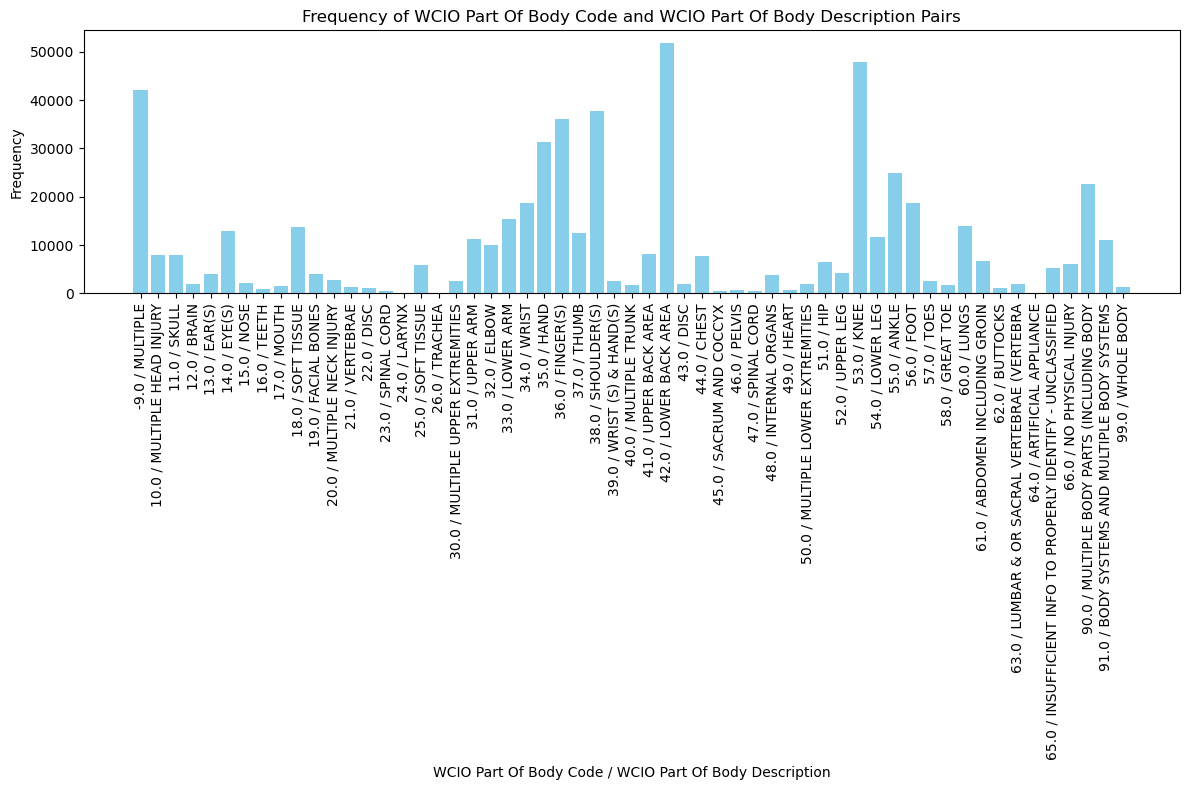

In [135]:
for code_col, desc_col in zip(df_codes.columns, df_description.columns):    
    code_column = code_col
    description_column = desc_col

    # Count occurrences of each code/description pair
    code_description_counts = X_train.groupby([code_column, description_column]).size().reset_index(name='Count').sort_index()

    # Plotting
    plt.figure(figsize=(12, 8))
    plt.bar(
        x=code_description_counts[code_column].astype(str) + ' / ' + code_description_counts[description_column],
        height=code_description_counts['Count'],
        color='skyblue'
    )

    # Formatting the plot
    plt.xlabel(f"{code_column} / {description_column}")
    plt.ylabel("Frequency")
    plt.title(f"Frequency of {code_column} and {description_column} Pairs")
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

We can use the mode to fill the missing values

In [136]:
def fill_missing_with_mode(df, columns):
    """
    Fill missing values in a code column with the most frequent code.
    
    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - code (str): The name of the column representing codes.
    
    Returns:
    - pd.DataFrame: The DataFrame with missing values in the code column filled.
    """
    # Find the most frequent code
    for column in columns:
        most_frequent_code = df[column].mode().iloc[0]  # Get the mode (most frequent value)
        
        # Use .loc to avoid SettingWithCopyWarning and fill NaNs
        df.loc[:, column] = df[column].fillna(most_frequent_code)
    
    # Use .infer_objects to avoid FutureWarning if dtype downcasting is a concern
    df = df.infer_objects(copy=False)
    
    return df

In [137]:
codes_columns = df_codes.columns.tolist()
description_columns = df_description.columns.tolist()

# fill missing values in df_codes and df_description separately
X_train = fill_missing_with_mode(X_train, codes_columns)
X_train = fill_missing_with_mode(X_train, description_columns)

# fill missing values for test data
X_test = fill_missing_with_mode(X_test, codes_columns)
X_test = fill_missing_with_mode(X_test, description_columns)

In [138]:
target_features.remove('OIICS Nature of Injury Description')
X_train[target_features].isnull().sum()/X_train.shape[0]*100

Carrier Name                         0.0
Attorney/Representative              0.0
Industry Code                        0.0
Industry Code Description            0.0
Medical Fee Region                   0.0
C-2 Date                             0.0
First Hearing Date                   0.0
WCIO Cause of Injury Code            0.0
WCIO Cause of Injury Description     0.0
WCIO Part Of Body Code               0.0
WCIO Part Of Body Description        0.0
WCIO Cause of Injury Description     0.0
WCIO Cause of Injury Code            0.0
WCIO Nature of Injury Description    0.0
dtype: float64